## Joint Underlying Contract


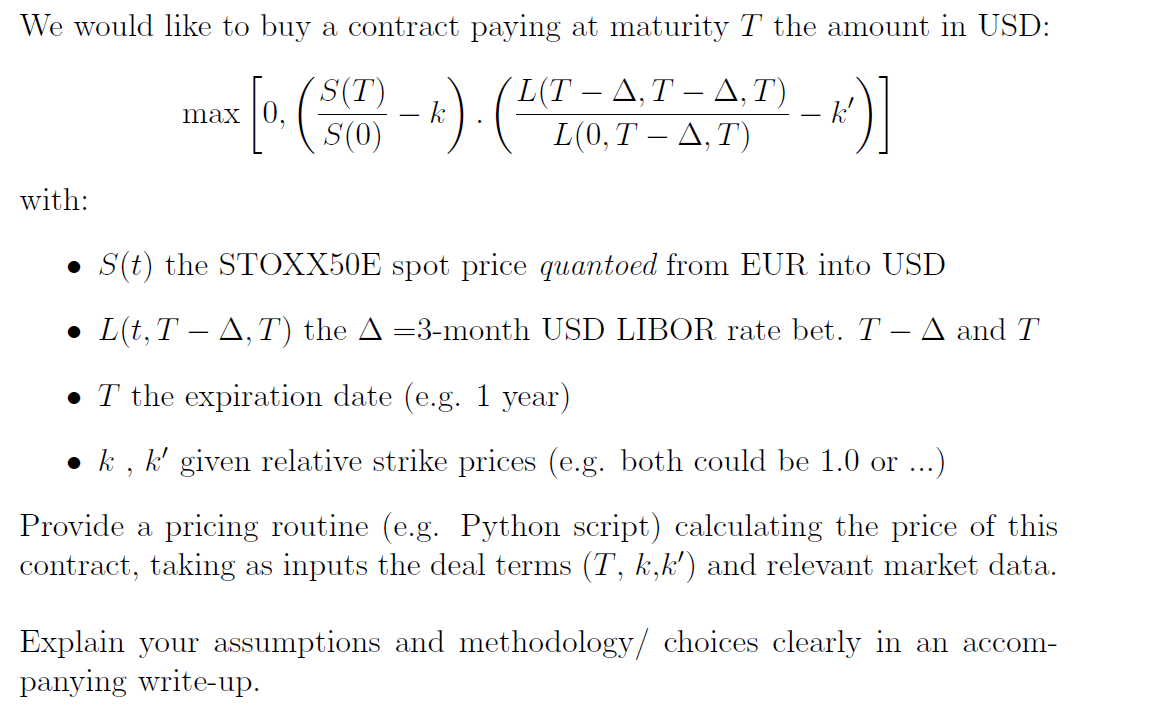

## Part 1: Project Overview
### Introduction

For this project, our goal was to create a robust pricing scheme for a hybrid product that involves the STOXX50E index and the LIBOR rate. We wanted to create a framework that would allow us to price this product based on relevant market data, and be able to analyse the product by having easily adjusted parameters in our model. Our main approach to pricing this contract was to use Monte Carlo simulation. There are several aspects of this contract that make it more complicated to price as opposed to a simple vanilla option contract. First, this product depends on both equity and interest rates which are not uncorrelated. This means we cannot simply use Monte Carlo on the equity part of the contract and the LIBOR part of the contract separately without taking into account the correlation. Another complication is that we want to price the contract in USD, but both STOXX50E and LIBOR are quoted in Euros. Another approach to this project, is to use a Gaussian Copula in order to get the correlation structure between the STOXX50E equity and the LIBOR Rate. This approach is arguably simpler and allows us to jump straight to maturity as opposed to the Monte Carlo approach which requires many small timesteps. Gaussian Copulas have however been criticized in recent history due to their part in the 2008 financial crisis. The gaussian distribution has light tails and does not accurately capture tail risk. This is arguably more of issue when pricing CDOs though, and would probably not be an issue for purposes of this project.

### Assumptions

1:	Arbitrage-Free Market

When pricing we worked under the no arbitrage assumption which is standard in asset pricing. Under this assumption, by the first fundamental asset pricing we can get a risk neutral pricing measure which is used to price the contract. 

2:	Market Completeness

Assuming market completeness is also pretty standard when it comes to asset pricing. Assuming that the market is complete, and then by the second fundamental theorem of asset pricing we have that our risk neutral pricing measure in an arbitrage free market is complete.

3:	Deterministic Euro Rates 

From a modelling perspective deterministic euro rates are used because it is unnecessary to introduce further randomness into an already random process when it will not affect our outcome. 

4:	Hull-White Model Assumptions

In our pricing scheme we used the Hull-White model. The Hull-White model assumes that short rates are normally distributed and mean-revert. 

5:	Equity Distribution
Returns of the STOXX50E were assumed to be log-normal. This is a pretty common assumption when modelling equity returns. 

6:	FX Volatility

FX volatility was backed out from FX options. We assumed using at the money options would be an accurate representation of this volatility. 

7:	Options Strike Price

We are assuming that both options and the caplets have strike prices at the money. 

8:	FX Distribution
We assume FX has lognormal distribution. 


### Step 0: Import statements, define useful Black Scholes functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import expon
import scipy.optimize
from scipy.interpolate import interp1d


%matplotlib inline
## BMS functions

def BMS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Merton Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BMS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Merton Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BMS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Merton Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BMS_d1(S, K, r, q, sigma, tau)
    d2 = BMS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price


### Step 1: Obtain Data
#### STOXX50E Prices, EUR/USD Prices, Call Prices for STOXX50E, Call Prices on EUR/USD, Caplet Prices

When using Monte Carlo simulation to price a financial contract, it is important to fit our model to market data while working under the arbitrage assumption. (i.e. The First Fundamental Theorem of Asset Pricing) For this project, our access to accurate market data was limited as University Students. The most accurate data that could be accessed was used, but implementing this pricing strategy at bank or a hedge with access to large amounts of market data would prove to be more fruitful and accurate. When fitting our model to market data, the prices of STOXX50E and LIBOR rates can be observed directly. In order to fit interest rate volatility, we used market data on caplets on which are calls on the LIBOR rate. From caplet prices, we are able to back out an implied volatility of the underlying LIBOR Rate. Similarly, we can use option prices on EUR/USD to get the implied volatility for the foreign exchange rate. For STOXX50E prices and EUR/USD conversion rate, we were able to get real data from Yahoo Finance. For call options on STOXX50E, call options on EUR/USD, and caplets we were not able to find a large amount of accurate data on the internet, and there used random numbers that we generated as data. For all three of these products, we looked at similar products to estimate roughly what the prices should be and then generated normal random variables with our estimation as the mean. The call options on STOXX50E follow a Normal(150,10) distribution. The call options on EUR/USD follow a Normal(.043,.003) distribution. The Caplet prices follow a Normal(.05,.004) distribution. 

In [2]:
Data = pd.read_csv("4735 Project Data.csv")
Data

,Date,STOXX50E Price,EUR/USD,Call Option on STOXX50E,Call on EUR/USD,Caplet Prices ($1 Notional)
0,4/26/2016,3121.290039,1.1299,160.721103,0.041996,0.049060
1,4/27/2016,3130.429932,1.1321,150.074349,0.039155,0.047989
2,4/28/2016,3125.429932,1.1353,147.643866,0.044886,0.054757
3,4/29/2016,3028.209961,1.1456,150.703992,0.037934,0.045335
4,5/2/2016,3032.600098,1.1532,144.413973,0.043672,0.052294
...,...,...,...,...,...,...
634,10/30/2018,3147.129883,1.1578,151.897816,0.040332,0.055508
635,10/31/2018,3197.510010,1.1548,143.993605,0.046953,0.047262
636,11/1/2018,3204.209961,1.1478,143.388142,0.038728,0.041540
637,11/2/2018,3214.409912,1.1515,157.887818,0.039560,0.056370


## Part 2: Rates

### Step 2: Peform Interpolation of the Yield Curve

We only have certain data points on the yield curve, but require the entire yield curve. In order to obtain the entire yield curve, we must use interpolation. We used quadratic interpolation here to do this. 

### Explanation:
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield

We used yield curve data from November 1st, 2019.

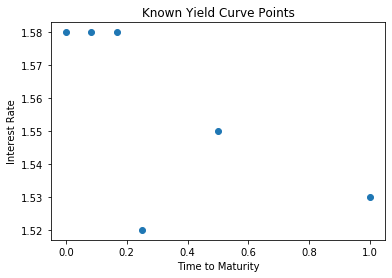

In [3]:
t = np.array([0, 1/12, 1/6, 0.25, 0.5, 1])
yc = np.array([1.58, 1.58, 1.58, 1.52, 1.55, 1.53])
plt.plot(t,yc,'o')
plt.title('Known Yield Curve Points')
plt.xlabel('Time to Maturity')
plt.ylabel('Interest Rate')
plt.show()

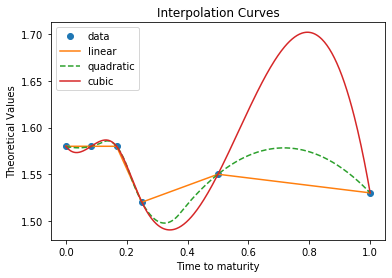

In [4]:
f = interp1d(t, yc)
f2 = interp1d(t, yc, kind='quadratic')
f3 = interp1d(t, yc, kind='cubic')
time = np.linspace(0, 1, num=367, endpoint=True)

plt.plot(t, yc, 'o', time, f(time), '-', time, f2(time), '--', time, f3(time))
plt.legend(['data', 'linear', 'quadratic', 'cubic'], loc='best')

plt.title('Interpolation Curves')
plt.xlabel('Time to maturity')
plt.ylabel('Theoretical Values')
plt.show()

As we can see, quadratic interpolation is the best

In [5]:
# we take quadratic interpolation
p = f2(time)
logp = - np.log(p)
# differentiation of -log(p) with respect to T

nbx = len(time)
tnew = np.zeros(nbx-1)
f = np.zeros(nbx-1)

for i in range(nbx-1): 
    tnew[i] = (time[i] + time[i+1]) / 2
    f[i] = (logp[i+1] - logp[i]) / (time[i+1] - time[i])
    
    
# differentiation of f with respect to T

nbx = len(time)-1
tnew2 = np.zeros(nbx-1)
fT = np.zeros(nbx-1)

for i in range(nbx-1): 
    tnew2[i] = (time[i] + time[i+1]) / 2
    fT[i] = (f[i+1] - f[i]) / (time[i+1] - time[i])


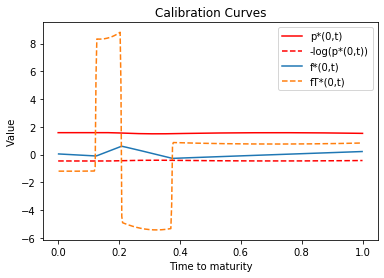

In [6]:
plt.plot(time, p, label='p*(0,t)', color ='red')
plt.plot(time, logp, '--', label='-log(p*(0,t))', color ='red')

plt.plot(tnew, f, label='f*(0,t)')
plt.plot(tnew2, fT, '--', label="fT*(0,t)")

plt.legend(loc ='best')
plt.title('Calibration Curves')
plt.xlabel('Time to maturity')
plt.ylabel('Value')
plt.show()

In [7]:
p = pd.Series(p)
f = pd.Series(f)
fT = pd.Series(fT)
p = pd.Series.drop(p,0)
p = pd.Series.drop(p,1)
p = pd.Series.reset_index(p)
p = p[0]
f = pd.Series.drop(f,0)
f = pd.Series.reset_index(f)
f = f[0]
calibration = {"p":p, "f":f, "fT":fT}

In p, we have $p^* (0,t)$ for t between day 1 to day 365

In f, we have $f^* (0,t)$ for t between day 1 to day 365

in fT, we have $f^*_T (0,t)$ for t between day 1 to day 365

### Step 3: Define the Hull White Structure (Short Rate)


We need to define the following :
\begin{aligned}L(t,S,T)&=-\frac{ p(t,T) - p(t,S)}{(T-S)p(t,T)}\\
p(t,T)&=\mathbb{E}[e^{-\int_{t}^{T} r_u du}]\\
f(t,T)&= - \frac{\partial log(p(t,T))}{\partial T}\end{aligned}

We propose the Hull-White model to model the short rate:
### \begin{aligned} dr&=(\Theta(t)-ar)dt + \sigma dW_t \end{aligned}
with $a$ and $\sigma$ as constants and $\Theta(t)$ as a function of time.

$r(t)$ is given by the following:
\begin{aligned} r_t &= r_0 e^{-at} + e^{-at} \int_{0}^{t} e^{-as} \Theta(s) ds + \sigma \int_{0}^{t} e^{-a(t-s)}dW_s \end{aligned}

We can compute $e^{-at} \int_{0}^{t} e^{-as} \Theta(s) ds$ easily using a numerical integration scheme.

Then we can simulate it by the following:

\begin{aligned} r_{i+1} = r_i e^{-a* \delta t} + e^{-a* t_{i+1}} * \int_{0}^{t_{i+1}} e^{-as} \Theta(s) ds + \sigma \sqrt{\frac{1-e^{-2a* \delta t}}{2a}} Z_{i+1} \end{aligned}

Using the affine term structure we have:
$ \begin{aligned} p(t,T)&=e^{A(t,T)-B(t,T)r(t)}\\B(t,T)&=\frac{1}{a}(1-e^{-a(T-t)})\\A(t,T)&=\int_{t}^{T} \left (\frac{1}{2} \sigma^2 B^2 (s,T) - \Theta(s)B(s,t)  \right ) ds\end{aligned} $

So:
$ \begin{aligned} p(t,T)&= \frac{p^* (0,T)}{p^* (0,t)} exp \left \{ B(t,T) f^* (0,t) - \frac{\sigma^2}{4a} B^2 (t,T) \left ( 1-e^{-2at} \right ) -B(t,T)r(t) \right \} \end{aligned} $

The calibration of $\Theta$ gives:
$ \begin{aligned} \Theta(t) &= f^*_T (0,T) -  \frac{\sigma^2}{a} \left ( e^{-at} - \frac{e^{-2at}}{a} \right ) + a\left ( f^* (0,T) + \frac{\sigma^2}{2} B^2 (0,t) \right )\end{aligned} $


### Step 4: Implied Rate Vol (in order to simuate HW)

$c(t,T,K,S)$ is the price at $t$ of a call option of maturity $T$ and strike $K$ on a zero coupon bond of maturity $S$.

We have the following arbitrage-free pricing formulas for the call.

$ \begin{aligned} c(t,T,K,S) &= p(t,S) \cdot N(d) - p(t,T) \cdot K \cdot N(d-\sigma_p)\\
d &= \frac{1}{\sigma_p} log \left(  \frac{p(t,S)}{Kp(t,T)} \right) + \frac{1}{2} \sigma_p \end{aligned}
\begin{aligned}\sigma_p &= \frac{1}{a} \left( 1 - e^{-a(S-T)}  \right) \sqrt{\frac{\sigma^2}{2a} \left( 1 - e^{-2a(T-t} \right) } \end{aligned} $

We need to find $\sigma$.

We are going to use this formula with:

- $t=0$
- $T=0.5$
- $S=1$

We use the formula above with $t = 0$ because it allows us to use the data from the market directly and not the $p$ from the simulation.

We define a function to compute the difference between the model price and the market price. Then, we solve for $\sigma_p$ by finding a root of the difference function i.e. if the difference between the two prices is zero, then we know the volatility. Finally, we compute $\sigma$ from $\sigma_p$ by inverting the formula that relates $\sigma_p$ and $\sigma$. Observe that a closed-form inverse exists for this formula, so no root-finding techniques must be utilized.

In [8]:
a = 0.02
# Compute d1 and d2
def d(sigma_p, S_index, T_index, K):
    d = 1/(sigma_p) * np.log( p[int(S_index)] / (p[int(T_index)]*K) ) + sigma_p/2
    return d

def price_call(sigma_p, S_index, T_index, K):
    d_1 = d(sigma_p, S_index, T_index, K)
    d_0 = d(sigma_p, S_index, T_index, K) - sigma_p
    
    price = p[S_index]*norm.cdf(d_1) - p[T_index]*K*norm.cdf(d_0)
    return price

def getDiff_call(vol, caplet, S_index, T_index, K):
    return caplet - price_call(vol, S_index, T_index, K)

def get_sig(sigma_p, T_index, S_index):
    sigma = (a*sigma_p * np.sqrt(2*a)) / (np.sqrt(1 - np.exp(-2*a*(T_index/365))) * (1- np.exp(-a*(S_index/365 - T_index/365))) )
    return(sigma)

In [9]:
Caplet = Data["Caplet Prices ($1 Notional)"]
Caplet = pd.Series(Caplet)
Caplet = Caplet[:365] # only one year

T_index = 182
S_index = 364

ImpVol_Caplet = np.zeros(len(Caplet))
upperBound = 2.0
lowerBound = 0.0

for i in range(0, len(ImpVol_Caplet)):
    v1 = scipy.optimize.bisect( getDiff_call, 0.01, 2, args=(Caplet[i]/20, S_index, T_index, p[S_index]))
    ImpVol_Caplet[i] = get_sig(v1, T_index, S_index)

### Step 5: Simulate HW 

In [10]:
# B (used to compute theta and p)
def B(t,T):
    return( (1 - np.exp(-T+t) )/a )

# theta calibrated
def theta(t_index):
    return(fT[t_index] - a * ImpVol_Caplet[t_index]**2 * np.exp(-2*a*t/365) + a*(f[t_index] + (ImpVol_Caplet[t_index]**2 * B(0,t/365)**2)/2 ))

theta_list = []
for t in range(365):
    theta_list += [theta(t)]
theta_serie = pd.Series(theta_list)

# Computation of the deterministic integral (second term in $r(t)$ formula)
def integral(t_index):
    s = 0
    aire = 0
    dt = 1/365
    while s <= t_index:
        y = np.exp(-a*s/365) * theta_serie[int(s)]
        small_aire = y*dt
        aire += small_aire
        s += 1
    return(aire)

# This computes the integral term in the HW simulation
int_list = []
for t in range(365):
    int_list += [integral(t)]
int_serie = pd.Series(int_list)

#safety
#assert statement
time = np.linspace(0, 1, num=365, endpoint=True)
len(time), len(f), len(p), len(fT), len(theta_serie), len(int_serie)

(365, 365, 365, 365, 365, 365)

Now we can simulate the interest rate process using Hull White.

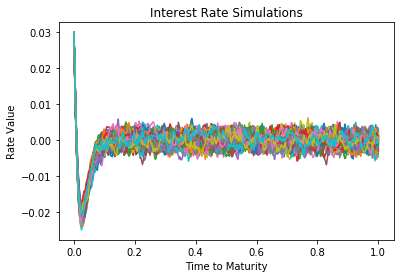

In [11]:
# Simulate r(t)
dt = 1/365
n_sims = 100
n_time_steps = len(time)
r = np.zeros((n_sims,n_time_steps))
r_0 = 0.03
r[:,0] = r_0
a=80
Z = scipy.stats.norm.rvs(size=r.shape)

# simulations

for i in range(n_sims):
    for j in range(1, n_time_steps):
        t = time[j]
        r[i,j] = r[i,j-1]*np.exp(-a*dt) + np.exp(-a*time[j])*int_serie[j] + (ImpVol_Caplet[j]/30)*np.sqrt((1-np.exp(-2*a*dt))/(2*a))*Z[i,j]

for n in range(n_sims):
    plt.plot(time, r[n,:])
    plt.title('Interest Rate Simulations')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Rate Value')

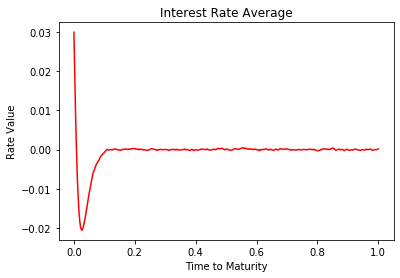

In [12]:
# We take the average on the simulations for each day t to obtain r(t)

r_serie = [r_0]

for t in range(1, n_time_steps):
    s = 0
    for i in range(n_sims):
        s = s + r[i,t]
    r_t = s/n_sims
    r_serie += [r_t]

r_serie = pd.Series(r_serie)
plt.plot(time, r_serie, label='r(t)',color='red')
plt.title('Interest Rate Average')
plt.xlabel('Time to Maturity')
plt.ylabel('Rate Value')
plt.show()

### Step 6: Compute p with HW

We now define p(t,T) as the price of a zero coupon bond starting on date t with maturity T. We can use the hull white model to solve for these zero coupon bond prices.

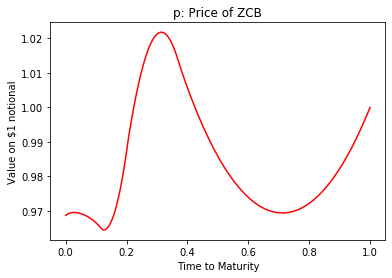

In [13]:
#p(t,T) computation
def p_t_T(t_index, T_index):
    p_fin = p[T_index]/p[t_index] * np.exp( B(t_index/365, T_index/365)*f[t_index] - ImpVol_Caplet[t_index]**2 * B(t_index/365,T_index/365)**2 * (1-np.exp(-2*a*t_index/365) / (4*a) ) - B(t_index/365,T_index/365) * r_serie[t] )
    return p_fin

p_list = []
for t in range(365):
    t = int(t)
    p_list += [p_t_T(t,364)]
p_serie = pd.Series(p_list)
plt.plot(time, p_serie, color='red')
plt.title('p: Price of ZCB')
plt.xlabel('Time to Maturity')
plt.ylabel('Value on $1 notional')
plt.show()

### Step 7: Compute L with p 

From our values of p we can then compute the value of LIBOR defined as L. L(t,s,T) is the LIBOR price at date t with start date s and end date T. 

In [14]:
#L(t,S,T) computation
def L(t,S,T):
    return( -( p_t_T(t,T) - p_t_T(t,S) ) / ((T-s) * p_t_T(t,T)) )

## Part 3: Stock

### Step 8: Compute the Implied Equity Volatility using HW

From the STOXX50E Calls, we applied an inverse BMS scheme. In order to use the Hull-White model, we must get the volatility of STOXX50E. In order to do this, we use data giving us a time series of call option prices on the STOXX50E as well as the STOXX50E prices. We then use inverse the Black-Scholes formula to find the implied volatility for each call option price with its corresponding price of the underlying STOXX50E.

In [15]:
#Function call for a bisection routine to generate the implied volatility
def diffQuotedAndMarketPrices( vol, DerivativePrice, type_option, S, K, r, q, T, t ):
    return DerivativePrice - BMS_price( type_option, S, K, r, q, vol, T, t  )

In [16]:
T = 1 # maturity in years
Calls_Equity = Data["Call Option on STOXX50E"]
Calls_Equity = pd.Series(Calls_Equity)
Calls_Equity = Calls_Equity[:T*365] # only one year
Equity = Data["STOXX50E Price"]
Equity = pd.Series(Equity)
Equity = Equity[:T*365] # only one year


ImpVol_Equity = np.zeros(len(Calls_Equity))
upperBound = 2.0
lowerBound = -1

for i in range(0, len(ImpVol_Equity)):
    ImpVol_Equity[i] = scipy.optimize.bisect( diffQuotedAndMarketPrices, lowerBound, upperBound,
                                             args=( Calls_Equity[i], 'call', Equity[i], Equity[i], r_serie[i], 0, T, 0))
    #to fix some floating point error
    if(ImpVol_Equity[i] < 1e-10):
        ImpVol_Equity[i] = 0


### Step 9: Compute the Implied FX Volatility
From the EUR/USD Calls, we applied an inverse BMS scheme. In order to get the implied FX volatility we use the same methodology as was used to get the implied equity volatility. The only difference is our data here is call options on EUR/USD and the underlying EUR/USD. We are assuming FX is a lognormal process.

In [17]:
T = 1 # maturity in years
Calls_FX = Data["Call on EUR/USD"]
Calls_FX = pd.Series(Calls_FX)
Calls_FX = Calls_FX[:T*365] # only one year
FX = Data["EUR/USD"]
FX = pd.Series(FX)
FX = FX[:T*365] # only one year


ImpVol_FX = np.zeros(len(FX))
upperBound = 2.0
lowerBound = -1

for i in range(0, len(ImpVol_FX)):
    ImpVol_FX[i] = scipy.optimize.bisect( diffQuotedAndMarketPrices, lowerBound, upperBound,
                                             args=( Calls_FX[i], 'call', FX[i], FX[i], r_serie[i], 0, T, 0))
    #to fix some floating point error
    if(ImpVol_FX[i] < 1e-10):
        ImpVol_FX[i] = 0

### Step 10 : Simulate the Equity,  Estimate r_f and q

We now simulate the equity price in domestic currency. The equity is quantoed because we simulated with r in the deomestic rate, but the STOXX data is in the EUR rate. So we use the quanto adjustment from the FX and the Equity process. In other words, the simulation performed above was used to calibrate LIBOR in the domestic numeraire but the STOXX data is in the foreign numeraire so the quanto adjustment is necessary.

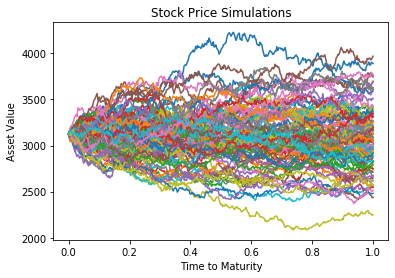

In [18]:
# Simulate S(t) in USD using the quanto adjustment
dt = 1/365
S = np.zeros((n_sims,n_time_steps))
S[:,0] = Equity[0]
Z = scipy.stats.norm.rvs(size=S.shape)

# simulations
Corr_Equity_FX = np.corrcoef(Equity, FX)[1,0]
r_serie_quantoed = r_serie - Corr_Equity_FX*ImpVol_Equity*ImpVol_FX
for i in range(0, n_sims):
    for j in range(1, n_time_steps):
        t = time[j]
        
        S[i,j] = S[i,j-1]*np.exp( (r_serie_quantoed[j] - ImpVol_Equity[j]**2/2)*dt + ImpVol_Equity[j]*np.sqrt(dt)*Z[i,j] )

for n in range(n_sims):
    plt.plot(time, S[n,:])
    plt.title('Stock Price Simulations')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Asset Value')

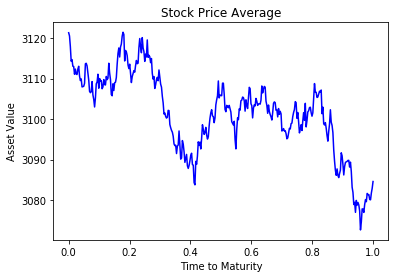

In [19]:
# We take the average on the simulations for each day t to obtain r(t)

S_serie = [S[0,0]]

for t in range(1, n_time_steps):
    s = 0
    for i in range(n_sims):
        s = s + S[i,t]
    S_t = s/n_sims
    S_serie += [S_t]

S_serie = pd.Series(S_serie)
plt.plot(time, S_serie, label='S(t)',color='blue')
plt.title('Stock Price Average')
plt.xlabel('Time to Maturity')
plt.ylabel('Asset Value')
plt.show()

## Part 4: Model Integration

### Step 11: Construct the Payoff function

This function gives us the price of our contract for our simulated values.

In [20]:
def PayoffFnc(Strike1, Strike2, S_T, S_0, L_T, L_0):
    return max(0, (S_T/S_0 - Strike1)*(L_T/L_0 - Strike2) )

### Step 12: Structure the Code to run in a loop

We now run many simulations of our code and take the average price as our expected payoff.

In [21]:
STRIKE1 = np.linspace(0.5, 1.5, num = 11)
STRIKE2 = np.linspace(0.5, 1.5, num = 11)

PayoffMat = np.zeros ( shape = (n_sims, len(STRIKE1), len(STRIKE2)), dtype = float)

ContractPriceSimul = np.zeros ( shape = (n_sims, len(STRIKE1), len(STRIKE2)), dtype = float)

T = 364
T_delT = int(0.75*T)
for i in range(0, n_sims):
    for aa in range(0, len(STRIKE1)):
        for bb in range(0, len(STRIKE2)):
            PayoffMat[i,aa,bb] = PayoffFnc( aa, bb, S[i,T], S[i,0], L(T, 273, T), L(0, 273, T) )
            ContractPriceSimul[i,aa,bb] = np.exp(-np.sum(r[i,0:T]))*PayoffMat[i,aa,bb]

ContractPrice = np.zeros ( shape = ( len(STRIKE1), len(STRIKE2)), dtype = float)
for aa in range(0, len(STRIKE1)):
    for bb in range(0, len(STRIKE2)):
        ContractPrice[aa,bb] = np.mean(ContractPriceSimul[:,aa,bb])

Text(0.5, 0, 'Payoff')

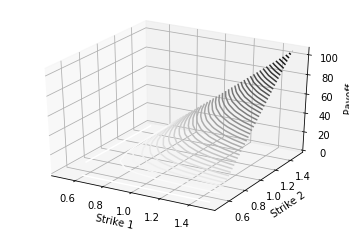

In [22]:
from mpl_toolkits import mplot3d

def f(x, y):
    return ContractPrice[x,y]



X, Y = np.meshgrid(STRIKE1, STRIKE2)

XIDX = np.arange(0, len(STRIKE1)-1)
YIDX = np.arange(0, len(STRIKE2)-1)
Z = ContractPrice

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('Strike 1')
ax.set_ylabel('Strike 2')
ax.set_zlabel('Payoff')

## Part 5: Analysis and Conclusion

### Conclusion

This project demonstrates how difficult and complicated it can be to try and accurately price financial contracts. The are several different ways that this problem can be approached, each with its own unique set of assumption. For this reason, different people may come up with different prices of the contract. This is why it's very important to understand your model and the assumption that you made. When dealing with large ammounts money like banks and hedge funds, small changes in prices can make a huge difference. 